# Computer Assignment 2, by Group 2
Ali Bemani

Oscar Bautista Gonzalez

Martin Hellkvist

## Summary of results
The methods GD, SGD, SVGR are working. 
There seems to be some issue with the implementation of SAG, which we could not figure out.
### Stepsize
Comprehensive summary of choice of stepsize as a function of $L$ ($\lambda=0.01$):
* $\alpha= \dfrac{1}{L}$ (See Figure 1):
    * GD: Converges. Goes beneath 0.25 around 500 iterations. Continues to decrease to end cost approximately 0.24 after 20000 iterations.
    * SGD: Large variance in gradients estimates, difficult to determine convergence.
    * SVRG: Same as for SGD.
    * SAG: No clear convergence. Has some large oscillatory behaviour.
* $\alpha= \dfrac{1}{16L}$ (See Figure 2):
    * GD: Converges. Cost beneath 0.26 around 500 iterations. Continues to decrease, cost very close to of 0.25 after 20000 iterations.
    * SGD: The envelope of the cost follows the cost of GD, but has some noise on top of it due to variance in the gradient estimates.
    * SVRG: Similiar to SGD, but the noise seems slightly lower (to the eye).
    * SAG: The large oscillatory behaviour is present, but less pronounced than for the larger step size.
    
For GD there seems to be no gain in decreasing the step size.
For SGD and SVRG, the noise level of the cost is much decreased by the lower step size.
The SAG implementation has some strange behaviour in its oscillations, it's possibly an **implementation error**.

### Regularization
With a larger regularization coefficient of $\lambda=10$, the overall convergence behaviour is the same for the two step size.
The main difference is for GD, which converges to its end cost around iteration 500. 
The end cost is higher for a larger $\lambda$, thus the cost level that SGD and SVRG varies about is higher.

### Time consumption
We measured the consumed time for the 4 different methods. In Figure 3 there is a plot with the time consumed versus the number of iterations.
From slowest to quickest, the methods are (and their consumed time for 500 iterations):
1. GD    (1051.0 ms)
2. SAG   (68.8 ms)
3. SVRG  (21.9 ms)
4. SGD   (15.0 ms)

We conclude that GD is much slower than the other methods.
### Hyperparameter tuning
Because we can compute the smoothness $L$, and setting the stepsize to $1/L$, it is very simple to get GD up and running.
For SGD and SVRG, it seems that we need to have another scaling on $L$ to get low variance in the gradient estimates.

In our experiments we used only 10000 datapoints for training and testing. 
Increasing this number to say 100000, makes the runtime of the methods slow, and finding a good stepsize will take more time for SGD and SVRG.

The SAG method worked well for step size $1/L$ although it had dramatic oscillations.
This might be an implementation error.

### Memory usage
To see the memory usage with "resource" package, one needs to run this notebook on a linux machine. For example google colab, if you are not running Linux locally.
We ran the methods in the following order: SGD; SAG; SVRG; GD. 
The memory used by the session during the run of each method was:
* SGD: 
    * 813.318144 mb
* SAG: 
    * 823.525376 mb
* SVRG:
    * 827.850752 mb
* GD:
    * 828.932096 mb
    
We conclude that running SGD can use around 10 megabytes of memory less than the other three methods.

### Stop condition
We do not make use of the stop condition $\varepsilon$ because we investigate both the short- and long term behviour of the methods.

## Implementation

In [1]:
##imports from libraries
import pandas as pd
import numpy as np
import time
import math
import sys
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from IPython.core.debugger import set_trace


# the "resource" library is not available on windows. 
# if it can be imported, we can use it! For example, while running on google colab
try:
    import resource
    print("Succesfully imported 'resource' package")
except:
    print("Failed on importing 'resource' package")

Failed on importing 'resource' package


### Load the data:
We first load the data into ghgdata. We will only use 10000 data points in this implementation, so its enough to use 70 files.

In [2]:
N_sites = 70
N_cols = 327
dghg = 15
Nghg = N_sites * N_cols
ghgdata = np.zeros((dghg+1, Nghg))

pathprefix = "./Data/ghg_data/ghg_data/ghg.gid.site"
for i in range(N_sites):
    filename = pathprefix + str(i + 1).zfill(4) + ".dat"
    subdata = np.genfromtxt(filename, delimiter=" ")
    ghgdata[:,i*N_cols:(i+1)*N_cols] = subdata

ghgdata = ghgdata.T

### Define function to find the smoothness $L$ of the cost function, given a dataset:
We have that for $L$ to guarantee L-smoothness of $f(w)$, it must fulfill the following inequality:
$$ L \succcurlyeq \frac{1}{4N} \sum_i y_i^2 x_i x_i^T + 2\lambda  $$
$$  = \frac{1}{4N} Z^T Z +2\lambda, $$
$$ Z = \begin{bmatrix}y_1 x_1^T \\ \vdots\\ y_N x_N^T\end{bmatrix}.$$

Which is equivalent to $L \geq \frac{1}{4N}\lambda_{\max}(Z^T Z) + 2\lambda $, where $\lambda_{\max}(Z^T Z)$ is the largest eigenvalue of $Z^T Z$.

We implement the finding of the smallest $L$ in the function ``find_smoothness()``.

In [3]:
def find_smoothness(X, Y, lambda_):
    # finds smallest L to guarantee L-smoothness of the Logistic Ridge Regression, given data X, Y
    # we have found it analytically as the largest eigenvalue of (1/(4N)) * Z.T @ Z + 2 * lambda.
    
    N, d = X.shape
    assert Y.shape == (N,1)
    
    YX = Y * X
    Z = YX.T @ YX
    eigs, _ = np.linalg.eig((1/(4*N))*Z)
    L = np.max(eigs) + 2*lambda_
    
    return L

### Preprocessing of data...

### Preprocessing of the response variable
We use the first 15 variables of the data as inputs $x_i$, and the 16th row as output.
We found that using the raw output data came with some numerical issues, due to the products $y_i x_i$ being very large quite often.
We therefore threshold the output data into a binary variable in $\{-1,+1\}$.

We here load the ``ghgdata`` into ``X`` and ``Y`` matrices, and perform the thresholding on the ``Y`` matrix.

The plots show histograms of ``Y`` before and after thresholding.

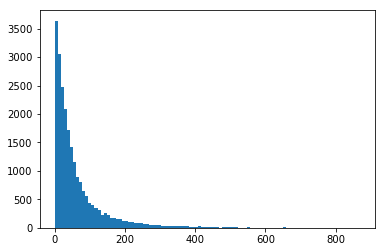

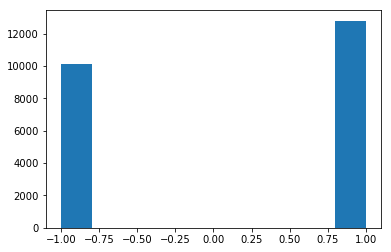

In [4]:
X = ghgdata[:, 0:dghg]
Y = ghgdata[:, [dghg]]
plt.figure(1)
_ = plt.hist(Y, bins=100)

# threshold Y to binary
threshold = 30
mask = Y < threshold
Y[mask] = -1
Y[~mask] = 1
plt.figure(2)
_ = plt.hist(Y)

### Split data into training and testing datasets
We are not really interested in finding a good classifier of the data, but only to verify our implementation of GD, SGD, SVRG and SAG.
Therefore we limit the simulations to only 10000 datapoints for training, to decrease the run time. We use 1000 data points for testing.

In [5]:
# Split train and test data here: (X_train, Y_train, X_test, Y_test)
N_train = 10000
N_test = 1000

# train_idx = np.random.choice(Nghg, size=N_train, replace=False)
train_idx = np.arange(N_train)
X_train = X[train_idx, :]
Y_train = Y[train_idx]

# test_idx_bool = ~np.isin(np.arange(Nghg), train_idx)
test_idx = np.arange(N_train, N_train + N_test)
X_test = X[test_idx, :]
Y_test = Y[test_idx]

## Implementing Cost and Gradient functions
#### The logistic ridge regression
$$ f(x) = \frac{1}{N}\sum_{i\in[N]} f_i(x) + \lambda\lVert w \rVert_2^2 $$
has the gradient: 
$$ \nabla f(x) = \frac{1}{N}\sum_{i\in[N]} \nabla f_i(x) + 2\lambda w, $$
$$ \nabla f_i(x) = -y_i x_i \frac{e^{-y_ix_i^T w}}{1 + e^{-y_ix_i^T w}} = -y_i x_i \frac{1}{1 + e^{y_i x_i^T w}}.$$
We use the latter form for computing gradients, since it has better numerical stability (the exponent can take "inf" values, thus the former form is undefined, while the latter is identically zero).

We define the gradient estimate for data point $i$ including regularization as:
$$  \hat{g}_i(w) = \nabla f_i(w) + 2\lambda w.$$

The ``cost()`` function is an implementation of $f(w)$.
The ``function_gradient()`` is an implementation of $\nabla f(w)$, given ``X, Y`` and ``w``.

In [6]:
def cost(x, y, w, lambda_ = 0.01):
    N, d = x.shape
    value = np.sum(np.log(1 + np.exp(- y*x @ w)))
    norm_w = np.linalg.norm(w)
    c = lambda_ * norm_w ** 2
    return value/N + c 

def function_gradient(X, Y, w, lambda_):
    N, d = X.shape
    assert Y.shape == (N,1)
    assert w.shape == (d,1)
    output = np.zeros((N,1))
    YX = Y * X # (N,d)
    YXw = YX @ w # (N,1)
    exp_vec = 1/(1 + np.exp(YXw)) # (N,1)
    grad_array = -YX * exp_vec # (N,d)
    output = np.sum(grad_array, axis=0) # (1,d)
    output = (1/N) * output.reshape(d,1) + 2 * lambda_ * w # (d,1)
    return output # (d,1)

### Implementing the gradient methods

In [7]:
def solver(x, y, w, alpha, num_iters, lambda_, epsilon, optimizer = "GD", mem=False, return_cost=False, verbose=True):
    if (optimizer == "GD"):
        cost_ = np.zeros(num_iters)
        for i in range(num_iters):
            g = function_gradient(x, y, w, lambda_) # compute the exact gradient wrt w, given x and y
            w = w - alpha * g # GD update
            
            if return_cost:
                cost_[i] = cost(X_test, Y_test, w, lambda_)
            
            if (i%10==0) and (mem) and ('resource' in sys.modules) and (verbose):
                usage=resource.getrusage(resource.RUSAGE_SELF)
                print("mem for GD (mb):", (usage[2]*resource.getpagesize())/1000000.0)
                        
            if (np.linalg.norm(g) <= epsilon):
                print("GD: Stop on condition fulfilled! Number of iterations: ", i+1, "/", num_iters)
                break
        if verbose:
            print("GD: Number of iterations: ", num_iters, "/", num_iters)
            print("GD: final norm: ", np.linalg.norm(g))
                
    elif (optimizer == "SGD"):
        cost_ = np.zeros(num_iters)
        N, d = x.shape
        assert y.shape == (N,1)
        for i in range(num_iters):
            i_ = int(N*np.random.rand(1))
            x_ = x[[i_], :]
            y_ = y[[i_], :]
            
            g = function_gradient(x_, y_, w, lambda_) # compute gradient
            w = w - alpha * g # GD update 
            
            if return_cost:
                cost_[i] = cost(X_test, Y_test, w, lambda_)
            
            if (i%10==0) and (mem) and ('resource' in sys.modules) and (verbose):
                usage=resource.getrusage(resource.RUSAGE_SELF)
                print("mem for SGD (mb):", (usage[2]*resource.getpagesize())/1000000.0)
                
    elif (optimizer == "SVRG"):
        N, d = x.shape
        assert y.shape == (N,1)
        
        T = 1000 # epoch length
        K = math.floor(num_iters/T) # number of epochs, given number of iterations
        
        if K == 0:
            # only run for one epoch consisting of num_iters iterations
            K = 1
            T = num_iters
        if verbose:
            print("number of epochs: ", K)
        cost_ = np.zeros(T*K)
        
        for k in range(K):
            yx = y * x # (N, d)
            yxw = yx @ w # (N, 1)
            
            assert yx.shape == (N, d)
            assert yxw.shape == (N, 1)
            
            # G_ is equal to using function_gradient, but we need G_vec, so we compute it manually here
            exp_vec = 1/(1 + np.exp(yxw)) # (N, 1)
            
            G_vec = (-yx * exp_vec).reshape(d, N) + 2*lambda_*w # (d, N)
                                    
            G_ = (1/N) * np.sum(G_vec, axis=1, keepdims=1) # (d, 1)
            if (np.linalg.norm(G_) <= epsilon): # check the average gradient
                print("SVRG: Stop on condition fulfilled! Number of iterations: ", k*t, "/", num_iters)
                break
            
            assert G_vec.shape == (d, N)
            assert G_.shape == (d, 1)
            
            for t in range(T):
                i_ = int(N*np.random.rand(1))
                x_ = x[[i_], :] # (1, d)
                y_ = y[[i_], :] # (1, 1)
                g = function_gradient(x_, y_, w, lambda_) # (d, 1)
                assert g.shape == (d,1)
                assert G_vec[:, [i_]].shape == (d,1)
                assert G_.shape == (d,1)
                w = w - alpha*(g - G_vec[:, [i_]] + G_)
                
                if return_cost:
                    cost_[t + k*T] = cost(X_test, Y_test, w, lambda_)
                    
                if (t%10==0) and (mem) and ('resource' in sys.modules) and (verbose):
                    usage=resource.getrusage(resource.RUSAGE_SELF)
                    print("mem for SVRG (mb):", (usage[2]*resource.getpagesize())/1000000.0)
                    
        if (K > 0) and (verbose):
            print("SVRG: final norm: ", np.linalg.norm(g))
            
    elif (optimizer == "SAG"):
        N, d = x.shape
        assert y.shape == (N,1)
        
        # compute initial gradient estimates for all datapoints
        yx = y * x # (N, d)
        yxw = yx @ w # (N, 1)
        exp_vec = 1/(1 + np.exp(yxw)) # (N, 1)
        G_vec = np.zeros((d, N))
        cost_ = np.zeros(num_iters)
        for k in range(num_iters):
            i_ = int(N*np.random.rand(1))
            x_ = x[[i_], :] # (1, d)
            y_ = y[[i_], :] # (1, 1)
            g = function_gradient(x_, y_, w, lambda_) # (d, 1)
            G_vec[:, [i_]] = g # (d, N)
            w = w - (alpha/N) * np.sum(G_vec, axis=1, keepdims=1) # (d, 1)
            if return_cost:
                cost_[k] = cost(X_test, Y_test, w, lambda_)
                
            if (np.linalg.norm(g) <= epsilon):
                    print("SAG: Stop on condition fulfilled! Number of iterations: ", k, "/", num_iters)
                    break
                    
            if (k%10==0) and (mem) and ('resource' in sys.modules) and (verbose):
                    usage=resource.getrusage(resource.RUSAGE_SELF)
                    print("mem for SAG (mb):", (usage[2]*resource.getpagesize())/1000000.0)
        if verbose:
            print("final norm: ", np.linalg.norm(g))
    if return_cost:
        return w, cost_
    else:
        return w

### Setting the constant stepsize
In these implementations we are using constant stepsize.

We set regularization $\lambda=0.01$.

We set the step size as $\alpha=\dfrac{1}{aL}$ where we set $a=16$ to upscale the smoothness factor we found.
If we have $a=1$, i.e., $\alpha=\dfrac{1}{L}$, the gradient estimates found by SGD and SVRG become very noisy.

In [8]:
lambda_ = 0.01
epsilon = 0

Load ``Y_train`` and ``X_train`` into ``y`` and ``x``.
Initial guess ``w``:

In [9]:
y = Y_train
x = X_train
print("x: ", x.shape)
print("y: ", y.shape)
N, d = x.shape
w = np.random.rand(d,1)*0.01  # Initialization of w

x:  (10000, 15)
y:  (10000, 1)


In [10]:
L = find_smoothness(x, y, lambda_)
print("L: ", L)
a = 1
alpha = 1/(a*L)
alpha_string = "alpha = 1/({0}*L)".format(a) + ": "
print(alpha_string, alpha)

L:  4498.793513176702
alpha = 1/(1*L):  0.00022228181779649562


### Trial runs for the methods

In [11]:
#-------------------- GD Solver -----------------------
print(alpha)
num_iters = 1000 # change the value
start = time.time()
gd = solver(x, y, w, alpha, num_iters, lambda_, epsilon, optimizer = "GD", mem=False)
end = time.time()
print("Weights of GD after convergence: \n", gd.flatten())
cost_value = cost(X_test, Y_test, gd, lambda_) 
print("Cost of GD after convergence: ", cost_value)

print("Training time for GD: ", end-start)

0.00022228181779649562
GD: Number of iterations:  1000 / 1000
GD: final norm:  0.18316007025731101
Weights of GD after convergence: 
 [ 0.0035533   0.00089837 -0.00272355  0.00169887  0.00372719  0.00626762
 -0.02284289  0.00234545 -0.0077846   0.00766477 -0.01674446  0.02128151
 -0.0052925   0.0243756  -0.02561895]
Cost of GD after convergence:  0.24707054067700002
Training time for GD:  2.3833413124084473


In [12]:
#-------------------- SGD Solver -----------------------
num_iters = 100 # change the value
start = time.time()
sgd = solver(x, y, w, alpha, num_iters, lambda_, epsilon, optimizer = "SGD", mem=False)
end = time.time()
print("Weights of SGD after convergence: \n", sgd.flatten())

cost_value = cost(X_test, Y_test, sgd, lambda_)  # Calculate the cost value
print("Cost of SGD after convergence: ", cost_value)

print("Training time for SGD: ", end-start)

Weights of SGD after convergence: 
 [ 0.00374795  0.00289073  0.0022203   0.00230396  0.00395332  0.0063278
  0.0047201   0.00990289 -0.00012075  0.00802694  0.00322156  0.02489573
 -0.00449946  0.02499798  0.00199709]
Cost of SGD after convergence:  0.2501800338911494
Training time for SGD:  0.005611896514892578


In [13]:
#-------------------- SVRG Solver -----------------------
num_iters = 10000 # change the value
start = time.time()
svrg = solver(x, y, w, alpha, num_iters, lambda_, epsilon, optimizer="SVRG", mem=False)
end = time.time()
print("\nWeights of SVRG after convergence: \n", svrg.flatten())

cost_value = cost(X_test, Y_test, svrg, lambda_)
print("Cost of SVRG after convergence: ", cost_value)
print("Training time for SVRG: ", end-start)

number of epochs:  10
SVRG: final norm:  0.19282520753560495

Weights of SVRG after convergence: 
 [-0.07062269  0.07372464 -0.01327093  0.01160272 -0.03147831  0.05562113
  0.02159324 -0.16309098  0.02506604  0.00386299 -0.07095504  0.034215
  0.02441423  0.03511978 -0.08629869]
Cost of SVRG after convergence:  0.2426431866854316
Training time for SVRG:  0.4874997138977051


In [14]:
#-------------------- SAG Solver -----------------------
num_iters = 10000 # change the value
start = time.time()
sag = solver(x, y, w, alpha, num_iters, lambda_, epsilon, optimizer="SAG", mem=False)
end = time.time()
print("Weights of SAG after convergence: \n", sag.flatten())

cost_value = cost(X_test, Y_test, sag, lambda_)
print("Cost of SAG after convergence: ", cost_value)
print("Training time for SAG: ", end-start)

final norm:  10.537022067527303
Weights of SAG after convergence: 
 [ 0.0029159  -0.00534279 -0.0176824  -0.000238    0.00301419  0.00606615
 -0.10710916 -0.01893587 -0.03083062  0.00760333 -0.0767942   0.0250108
 -0.02537349  0.03257528 -0.1180692 ]
Cost of SAG after convergence:  0.24717961065366456
Training time for SAG:  1.3887953758239746


### Here we create the plots interesting for the results
#### The displayed cost is the cost on the test data set X_test, Y_test

In [15]:
## Executing the iterations and plot the cost function here:
a = 1
alpha = 1/(a*L)
alpha_string = "alpha = 1/({0}*L)".format(a) + ": "
print(alpha_string, alpha)

n_sims = 1
I_max = 20000
cost_1= np.zeros((I_max,4))
for n in range(n_sims):
    w = np.random.rand(d,1)*0.01
    
    print("......",n+1,".......")
    #--------------GD-------------------
    gd, gd_cost  = solver(x, y, w, alpha, I_max, lambda_, epsilon, optimizer="GD", mem=False, return_cost=True, verbose=False)

    cost_1[:,0] += gd_cost/n_sims

    #---------------SGD------------------
    sgd, sgd_cost = solver(x, y, w, alpha, I_max, lambda_, epsilon, optimizer="SGD", mem=False, return_cost=True, verbose=False)

    cost_1[:,1] += sgd_cost/n_sims
    
    #---------------SVRG----------------
    svrg, svrg_cost = solver(x, y, w, alpha, I_max, lambda_, epsilon, optimizer="SVRG", mem=False, return_cost=True, verbose=False)

    cost_1[:,2] += svrg_cost/n_sims
    
    #---------------SAG------------------
    sag, sag_cost = solver(x, y, w, alpha, I_max, lambda_, epsilon, optimizer="SAG", mem=False, return_cost=True, verbose=False)
    
    cost_1[:,3] += sag_cost/n_sims
    
    #------------------------------------

alpha = 1/(1*L):  0.00022228181779649562
...... 1 .......


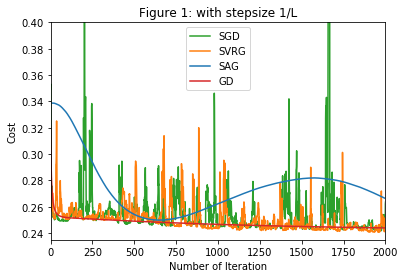

In [21]:
## PLOTs
l1 = plt.plot(cost_1[:,1],color="C2", label='SGD')
l2 = plt.plot(cost_1[:,2],color="C1", label='SVRG')
l3 = plt.plot(cost_1[:,3],color="C0", label='SAG')
l0 = plt.plot(cost_1[:,0],color="C3", label='GD')
# complete other plots here: 

plt.xlabel("Number of Iteration")
plt.ylabel("Cost")
plt.legend()

plt.ylim(0.235, .4)
plt.xlim(0,2000)
_ = plt.title('Figure 1: with stepsize 1/L')

In [17]:
## Executing the iterations and plot the cost function here:
a = 16
alpha = 1/(a*L)
alpha_string = "alpha = 1/({0}*L)".format(a) + ": "
print(alpha_string, alpha)

n_sims = 1
I_max = 20000
ti= np.zeros((I_max,4))
cost_2= np.zeros((I_max,4))
for n in range(n_sims):
    w = np.random.rand(d,1)*0.01
    
    print("......",n+1,".......")
    #--------------GD-------------------
    gd, gd_cost  = solver(x, y, w, alpha, I_max, lambda_, epsilon, optimizer="GD", mem=False, return_cost=True, verbose=False)

    cost_2[:,0] += gd_cost/n_sims

    #---------------SGD------------------
    sgd, sgd_cost = solver(x, y, w, alpha, I_max, lambda_, epsilon, optimizer="SGD", mem=False, return_cost=True, verbose=False)

    cost_2[:,1] += sgd_cost/n_sims
    
    #---------------SVRG----------------
    svrg, svrg_cost = solver(x, y, w, alpha, I_max, lambda_, epsilon, optimizer="SVRG", mem=False, return_cost=True, verbose=False)

    cost_2[:,2] += svrg_cost/n_sims
    
    #---------------SAG------------------
    sag, sag_cost = solver(x, y, w, alpha, I_max, lambda_, epsilon, optimizer="SAG", mem=False, return_cost=True, verbose=False)
    
    cost_2[:,3] += sag_cost/n_sims
    
    #------------------------------------

alpha = 1/(16*L):  1.3892613612280977e-05
...... 1 .......


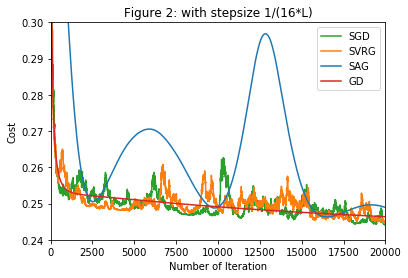

In [18]:
## PLOTs
l1 = plt.plot(cost_2[:,1], color="C2", label='SGD')
l2 = plt.plot(cost_2[:,2], color="C1", label='SVRG')
l3 = plt.plot(cost_2[:,3], color="C0", label='SAG')
l0 = plt.plot(cost_2[:,0], color="C3", label='GD')
# complete other plots here: 

plt.xlabel("Number of Iteration")
plt.ylabel("Cost")
plt.legend()

plt.ylim(0.24, .30)
plt.xlim(0, 20000)
_ = plt.title('Figure 2: with stepsize 1/(16*L)')

In [19]:
## Executing the iterations and plot the cost function here:
I_max = 500
ti= np.zeros((I_max,4))
cost_= np.zeros((I_max,4))
w = np.random.rand(d,1)*0.01
for i in range(I_max):
    print("......",i,".......")
    #--------------GD-------------------
    start = time.time()
    gd = solver(x, y, w, alpha, i+1, lambda_, epsilon, optimizer="GD", mem=False)
    end = time.time()

    cost_[i,0] = cost(X_test, Y_test, gd, lambda_)

    ti[i,0] = end-start

    #---------------SGD------------------
    start = time.time()
    sgd = solver(x, y, w, alpha, i+1, lambda_, epsilon, optimizer="SGD", mem=False)
    end = time.time()

    cost_[i,1] = cost(X_test, Y_test, sgd, lambda_)

    ti[i,1] = end-start
    
    #---------------SVRG----------------
    start = time.time()
    svrg = solver(x, y, w, alpha, i+1, lambda_, epsilon, optimizer="SVRG", mem=False)
    end = time.time()

    cost_[i,2] = cost(X_test, Y_test, svrg, lambda_)

    ti[i,2] = end-start
    
    #---------------SAG------------------
    start = time.time()
    sag = solver(x, y, w, alpha, i+1, lambda_, epsilon, optimizer="SAG", mem=False)
    end = time.time()

    cost_[i,3] = cost(X_test, Y_test, sag, lambda_)

    ti[i,3] = end-start
    
    #------------------------------------
    
    ## Pl the results:
    

...... 0 .......
GD: Number of iterations:  1 / 1
GD: final norm:  10.69524546888489
number of epochs:  1
SVRG: final norm:  2.5367517742673025
final norm:  23.783687594294445
...... 1 .......
GD: Number of iterations:  2 / 2
GD: final norm:  10.451055975097969
number of epochs:  1
SVRG: final norm:  22.167808588144773
final norm:  12.396819729713721
...... 2 .......
GD: Number of iterations:  3 / 3
GD: final norm:  10.219112326987268
number of epochs:  1
SVRG: final norm:  5.205831298583452
final norm:  47.01009342912832
...... 3 .......
GD: Number of iterations:  4 / 4
GD: final norm:  9.998459627751107
number of epochs:  1
SVRG: final norm:  0.7665299217180996
final norm:  45.366896922244884
...... 4 .......
GD: Number of iterations:  5 / 5
GD: final norm:  9.78824183139481
number of epochs:  1
SVRG: final norm:  3.6440860628712137
final norm:  15.228933926212477
...... 5 .......
GD: Number of iterations:  6 / 6
GD: final norm:  9.587689223573763
number of epochs:  1
SVRG: final nor

GD: Number of iterations:  49 / 49
GD: final norm:  5.240703925345474
number of epochs:  1
SVRG: final norm:  0.5718951190605587
final norm:  7.647040932982228
...... 49 .......
GD: Number of iterations:  50 / 50
GD: final norm:  5.1875148145732775
number of epochs:  1
SVRG: final norm:  16.316814450483047
final norm:  2.2042649140164645
...... 50 .......
GD: Number of iterations:  51 / 51
GD: final norm:  5.135409276684563
number of epochs:  1
SVRG: final norm:  16.50749585219278
final norm:  15.711102100351528
...... 51 .......
GD: Number of iterations:  52 / 52
GD: final norm:  5.08435235530977
number of epochs:  1
SVRG: final norm:  18.361632138475468
final norm:  20.45911202327358
...... 52 .......
GD: Number of iterations:  53 / 53
GD: final norm:  5.03431063382528
number of epochs:  1
SVRG: final norm:  14.537391180586148
final norm:  0.4511081285781123
...... 53 .......
GD: Number of iterations:  54 / 54
GD: final norm:  4.985252149862404
number of epochs:  1
SVRG: final norm: 

GD: Number of iterations:  95 / 95
GD: final norm:  3.555844740114645
number of epochs:  1
SVRG: final norm:  8.981803526670438
final norm:  24.755770617224854
...... 95 .......
GD: Number of iterations:  96 / 96
GD: final norm:  3.530819113139627
number of epochs:  1
SVRG: final norm:  17.646511325316023
final norm:  21.16420558731916
...... 96 .......
GD: Number of iterations:  97 / 97
GD: final norm:  3.506120940112657
number of epochs:  1
SVRG: final norm:  14.791912995507216
final norm:  33.61164148299187
...... 97 .......
GD: Number of iterations:  98 / 98
GD: final norm:  3.4817434874815407
number of epochs:  1
SVRG: final norm:  12.247649735035381
final norm:  1.618934112655404
...... 98 .......
GD: Number of iterations:  99 / 99
GD: final norm:  3.4576802119130843
number of epochs:  1
SVRG: final norm:  22.772594486686764
final norm:  3.114326978894073
...... 99 .......
GD: Number of iterations:  100 / 100
GD: final norm:  3.433924753488147
number of epochs:  1
SVRG: final nor

GD: Number of iterations:  141 / 141
GD: final norm:  2.6652119334103124
number of epochs:  1
SVRG: final norm:  0.6890085400306769
final norm:  5.2019437448951535
...... 141 .......
GD: Number of iterations:  142 / 142
GD: final norm:  2.6503555875317995
number of epochs:  1
SVRG: final norm:  14.822062673108103
final norm:  8.061948905398832
...... 142 .......
GD: Number of iterations:  143 / 143
GD: final norm:  2.635643971559845
number of epochs:  1
SVRG: final norm:  4.10246023729305
final norm:  38.43869747166265
...... 143 .......
GD: Number of iterations:  144 / 144
GD: final norm:  2.621074905593503
number of epochs:  1
SVRG: final norm:  16.253211381024123
final norm:  0.058837202201179106
...... 144 .......
GD: Number of iterations:  145 / 145
GD: final norm:  2.6066462550314906
number of epochs:  1
SVRG: final norm:  16.432711549730996
final norm:  6.920843184486149
...... 145 .......
GD: Number of iterations:  146 / 146
GD: final norm:  2.5923559293767893
number of epochs:

GD: Number of iterations:  187 / 187
GD: final norm:  2.104572498963811
number of epochs:  1
SVRG: final norm:  13.479525085417235
final norm:  4.543035824338523
...... 187 .......
GD: Number of iterations:  188 / 188
GD: final norm:  2.094651693303853
number of epochs:  1
SVRG: final norm:  12.230984850722772
final norm:  42.6853027065896
...... 188 .......
GD: Number of iterations:  189 / 189
GD: final norm:  2.0848087994693194
number of epochs:  1
SVRG: final norm:  22.35077130762528
final norm:  3.3431560639297464
...... 189 .......
GD: Number of iterations:  190 / 190
GD: final norm:  2.0750428931871427
number of epochs:  1
SVRG: final norm:  6.2971305813256695
final norm:  3.2712749452944396
...... 190 .......
GD: Number of iterations:  191 / 191
GD: final norm:  2.065353065361276
number of epochs:  1
SVRG: final norm:  12.079660784587023
final norm:  37.07554495007551
...... 191 .......
GD: Number of iterations:  192 / 192
GD: final norm:  2.0557384217556796
number of epochs:  1

GD: Number of iterations:  233 / 233
GD: final norm:  1.716929883150818
number of epochs:  1
SVRG: final norm:  1.9479818292036863
final norm:  10.403659084086884
...... 233 .......
GD: Number of iterations:  234 / 234
GD: final norm:  1.709824166929475
number of epochs:  1
SVRG: final norm:  1.1461179676330753
final norm:  43.44133286300282
...... 234 .......
GD: Number of iterations:  235 / 235
GD: final norm:  1.702765785179125
number of epochs:  1
SVRG: final norm:  7.466876716835053
final norm:  26.72474259094134
...... 235 .......
GD: Number of iterations:  236 / 236
GD: final norm:  1.6957542752568906
number of epochs:  1
SVRG: final norm:  17.713832941870468
final norm:  43.90358287659516
...... 236 .......
GD: Number of iterations:  237 / 237
GD: final norm:  1.6887891807932516
number of epochs:  1
SVRG: final norm:  13.459157213194809
final norm:  16.268464759237528
...... 237 .......
GD: Number of iterations:  238 / 238
GD: final norm:  1.6818700515836666
number of epochs:  

GD: Number of iterations:  279 / 279
GD: final norm:  1.43292888511782
number of epochs:  1
SVRG: final norm:  3.829874409352695
final norm:  45.69974837100303
...... 279 .......
GD: Number of iterations:  280 / 280
GD: final norm:  1.427601912803875
number of epochs:  1
SVRG: final norm:  4.9593047424181
final norm:  30.909183497713187
...... 280 .......
GD: Number of iterations:  281 / 281
GD: final norm:  1.4223061464929132
number of epochs:  1
SVRG: final norm:  4.570567428065533
final norm:  22.400516151025688
...... 281 .......
GD: Number of iterations:  282 / 282
GD: final norm:  1.4170413270039448
number of epochs:  1
SVRG: final norm:  5.00469536255581
final norm:  29.557748027003935
...... 282 .......
GD: Number of iterations:  283 / 283
GD: final norm:  1.4118071981460454
number of epochs:  1
SVRG: final norm:  14.5574343979164
final norm:  1.671594446892496
...... 283 .......
GD: Number of iterations:  284 / 284
GD: final norm:  1.4066035066742175
number of epochs:  1
SVRG:

GD: Number of iterations:  325 / 325
GD: final norm:  1.2166860905463681
number of epochs:  1
SVRG: final norm:  4.022277167449893
final norm:  3.9072299525433523
...... 325 .......
GD: Number of iterations:  326 / 326
GD: final norm:  1.2125654806446757
number of epochs:  1
SVRG: final norm:  13.549150920523168
final norm:  34.86900462132368
...... 326 .......
GD: Number of iterations:  327 / 327
GD: final norm:  1.2084666890350257
number of epochs:  1
SVRG: final norm:  12.229615286345151
final norm:  1.1471509325990221
...... 327 .......
GD: Number of iterations:  328 / 328
GD: final norm:  1.2043895581732171
number of epochs:  1
SVRG: final norm:  22.712632899764905
final norm:  1.710699553057511
...... 328 .......
GD: Number of iterations:  329 / 329
GD: final norm:  1.2003339320944992
number of epochs:  1
SVRG: final norm:  14.888140243775439
final norm:  8.013458067787429
...... 329 .......
GD: Number of iterations:  330 / 330
GD: final norm:  1.1962996563933561
number of epochs

GD: Number of iterations:  371 / 371
GD: final norm:  1.0475610425607054
number of epochs:  1
SVRG: final norm:  0.44506942548149186
final norm:  38.75563522407275
...... 371 .......
GD: Number of iterations:  372 / 372
GD: final norm:  1.044302064139964
number of epochs:  1
SVRG: final norm:  3.915891485120076
final norm:  2.229541728745035
...... 372 .......
GD: Number of iterations:  373 / 373
GD: final norm:  1.04105902820648
number of epochs:  1
SVRG: final norm:  1.7812959827452273
final norm:  8.249419932314195
...... 373 .......
GD: Number of iterations:  374 / 374
GD: final norm:  1.0378318328579514
number of epochs:  1
SVRG: final norm:  10.05406059592505
final norm:  15.490460815437487
...... 374 .......
GD: Number of iterations:  375 / 375
GD: final norm:  1.0346203770935998
number of epochs:  1
SVRG: final norm:  11.062095234345751
final norm:  23.74724850024476
...... 375 .......
GD: Number of iterations:  376 / 376
GD: final norm:  1.0314245608039134
number of epochs:  1

GD: Number of iterations:  417 / 417
GD: final norm:  0.9127358726102845
number of epochs:  1
SVRG: final norm:  13.963172164791393
final norm:  3.5239570617728777
...... 417 .......
GD: Number of iterations:  418 / 418
GD: final norm:  0.9101169622910185
number of epochs:  1
SVRG: final norm:  6.229271325397418
final norm:  7.848120730188169
...... 418 .......
GD: Number of iterations:  419 / 419
GD: final norm:  0.907510104329736
number of epochs:  1
SVRG: final norm:  5.274946766465043
final norm:  40.735404788233545
...... 419 .......
GD: Number of iterations:  420 / 420
GD: final norm:  0.9049152294832264
number of epochs:  1
SVRG: final norm:  10.548782801489638
final norm:  4.336259079908207
...... 420 .......
GD: Number of iterations:  421 / 421
GD: final norm:  0.9023322690547511
number of epochs:  1
SVRG: final norm:  0.20374840610214817
final norm:  13.182574280299507
...... 421 .......
GD: Number of iterations:  422 / 422
GD: final norm:  0.8997611548883782
number of epochs

GD: Number of iterations:  463 / 463
GD: final norm:  0.8037711605392948
number of epochs:  1
SVRG: final norm:  20.19468250160066
final norm:  4.23424838648442
...... 463 .......
GD: Number of iterations:  464 / 464
GD: final norm:  0.8016424583135399
number of epochs:  1
SVRG: final norm:  3.720675930200125
final norm:  14.871191798173406
...... 464 .......
GD: Number of iterations:  465 / 465
GD: final norm:  0.7995231137808123
number of epochs:  1
SVRG: final norm:  18.371176694880084
final norm:  6.886612040510272
...... 465 .......
GD: Number of iterations:  466 / 466
GD: final norm:  0.7974130779393553
number of epochs:  1
SVRG: final norm:  2.259974334341267
final norm:  2.987254877580955
...... 466 .......
GD: Number of iterations:  467 / 467
GD: final norm:  0.7953123021348006
number of epochs:  1
SVRG: final norm:  15.557290027453984
final norm:  2.2485602420079056
...... 467 .......
GD: Number of iterations:  468 / 468
GD: final norm:  0.7932207380568944
number of epochs:  

[1.05099607 0.01496029 0.02194142 0.06881595]


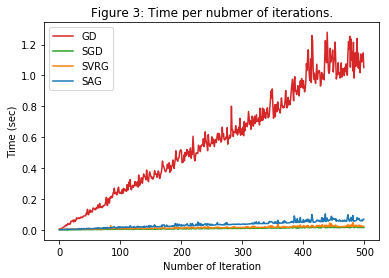

In [22]:
l0 = plt.plot(ti[:,0],color="C3",label="GD")
l1 = plt.plot(ti[:,1],color="C2",label="SGD")
l2 = plt.plot(ti[:,2],color="C1",label="SVRG")
l3 = plt.plot(ti[:,3],color="C0",label="SAG")
# complete other plots here:

plt.xlabel("Number of Iteration")
plt.ylabel("Time (sec)")
plt.legend()
_ = plt.title('Figure 3: Time per nubmer of iterations.')

print(ti[-1,:])